In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model


In [21]:
# Read the historical match data
df=pd.read_csv('../data/results.csv')
# df.index=pd.to_datetime(df['date'])
# df=df[df.index>'1945-01-01']
df.sort_index()
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [22]:
# A simplified version of the FIFA world ranking model:
# https://digitalhub.fifa.com/m/f99da4f73212220/original/edbm045h0udbwkqew35a-pdf.pdf

# Predicts the expected result: P(A) winning
# Based on the elo chess ranking system

# list of conf tournaments for weighting
confederation_tournaments=['AFC Asian Cup','African Cup of Nations','UEFA Euro','Copa América','CONCACAF Championship',
                           'Oceania Nations Cup']

# FIFA rankings weigh elo point exchanges by tournament
def k_value(tournament):
  k=5
  if tournament == 'Friendly':
      k=10
  elif tournament == 'FIFA World Cup qualification':
      k=25
  elif tournament in confederation_tournaments:
      k=40
  elif tournament == 'FIFA World Cup':
      k=55
  return k

# Calculate exp result
def expected_result(loc,aw):
  dr=loc-aw
  we=(1/(10**(-dr/600)+1))
  return [np.round(we,3),1-np.round(we,3)]

# Extract actual result
def actual_result(loc,aw):
  if loc<aw:
      wa=1
      wl=0
  elif loc>aw:
      wa=0
      wl=1
  elif loc==aw:
      wa=0.5
      wl=0.5
  return [wl,wa]

# Calculate elo point exchange
def calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament):
  k=k_value(tournament)
  wl,wv=actual_result(local_goals,away_goals)
  wel,wev=expected_result(elo_l,elo_v)
  
  elo_ln=elo_l+k*(wl-wel)
  elo_vn=elo_v+k*(wv-wev)
  
  return elo_ln,elo_vn
  

In [23]:
# Calculate ELO after each match in the archive
current_elo={}
for idx,row in df.iterrows():
    try:
        # print(row['date'])
        # Getting the data that it is nedeed to calculate the elo 
        local=row['home_team']
        away=row['away_team']
        local_goals=row['home_score']
        away_goals=row['away_score']
        tournament = row['tournament']
        
        # Getting elo before match. If it is the first match played, the elo is initialized to 1500.
        if local not in current_elo.keys():
            current_elo[local]=1500
        
        if away not in current_elo.keys():
            current_elo[away]=1500
        
        #calculating and updating elo
        elo_l=current_elo[local]
        elo_v=current_elo[away]
        elo_ln,elo_vn=calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament)

        current_elo[local]=elo_ln
        current_elo[away]=elo_vn
        
        #Saving results in dataframe
        df.loc[idx,'Elo_h_after']=elo_ln
        df.loc[idx,'Elo_a_after']=elo_vn 
        df.loc[idx,'Elo_h_before']=elo_l
        df.loc[idx,'Elo_a_before']=elo_v
    except Exception as e:
        print(e)

local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' referenced before assignment
local variable 'wl' 

<AxesSubplot:>

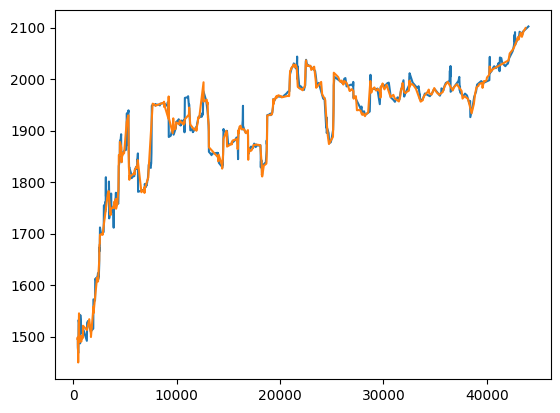

In [24]:
# Lets check Brazil's ELO for home and away games - they should be very similar
df[ ( df['home_team']=='Brazil' )]['Elo_h_after'].dropna().plot()
df[ ( df['away_team']=='Brazil' )]['Elo_a_after'].dropna().plot()

In [29]:
# Tidy up some country names
df['home_team'] = df['home_team'].replace(['United States'], 'USA')
df['away_team'] = df['away_team'].replace(['United States'], 'USA')
df['home_team'] = df['home_team'].replace(['South Korea'], 'Korea Republic')
df['away_team'] = df['away_team'].replace(['South Korea'], 'Korea Republic')

df.index=pd.to_datetime(df['date'])


In [30]:
# Get the world cup fixtures
world_cup_schedule=pd.read_csv('../data/fifa-world-cup-2022-UTC.csv')

# Extract the teams 
wc_teams=pd.unique(world_cup_schedule[['Home Team','Away Team']].values.ravel()).tolist()

# remove TBC match data
drop_list=['1A', '2B', '1C', '2D', '1D', '2C',
       '1B', '2A', '1E', '2F', '1G', '2H', '1F', '2E', '1H', '2G',
       'To be announced']

wc_teams=list(set(wc_teams) - set(drop_list))

In [31]:
# Build the rankings of the WC teams, combining their elo updates from home and away matches since 2012
def build_rankings():
    data={}
    for t in wc_teams:
        data[t]=pd.concat([df[ ( df['away_team']==t )]['Elo_a_after'],
        df[ ( df['home_team']==t )]['Elo_h_after']]).resample('1D').mean().loc['2012-01-01':'2022-11-01'].dropna()
    rankings=pd.DataFrame(data)
    rankings=rankings.interpolate(method='ffill')
    return rankings

In [32]:
rankings=build_rankings()

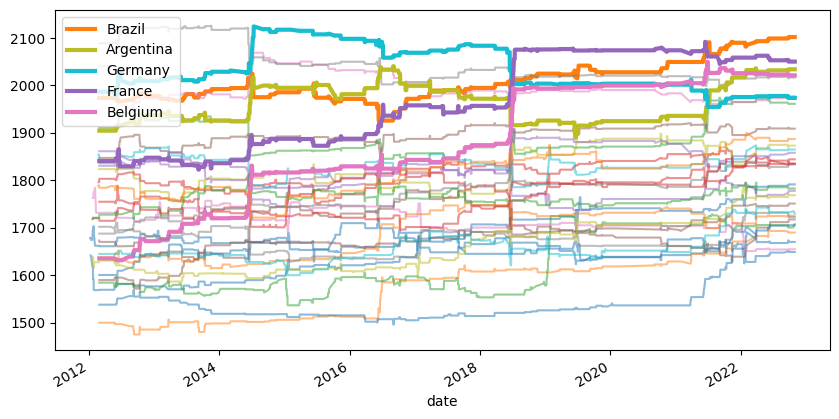

In [33]:
# Plot the ratings of the WC teams with a few favourites in bold
to_plot=['Brazil','Germany','Argentina','France','Belgium']

plt.figure(figsize=(10,5))
for t in wc_teams:
    if t in to_plot:
        rankings[t].plot(lw=3,label=t)
    else:
        rankings[t].plot(label='_',alpha=0.5)
plt.legend()

In [34]:
# Extract some feature data from the match and elo archive
feature_data={}

for t in wc_teams:
    print('Processing '+t)
    team_elo=[]
    opp_elo=[]
    gs=[]
    gc=[]
    result=[]
    for idx,row in df[df.index>'2014-01-01'].iterrows():

        # for home games
        if row['home_team']==t:
            team_elo.append(row['Elo_h_before'])
            opp_elo.append(row['Elo_a_before'])
            gs.append(row['home_score'])
            gc.append(row['away_score'])
            if row['home_score']>row['away_score']:
                result.append(1)
            elif row['home_score']<row['away_score']:
                result.append(0)
            else:
                result.append(0.5)
        
        # for away games
        elif row['away_team']==t:
            team_elo.append(row['Elo_a_before'])
            opp_elo.append(row['Elo_h_before'])
            gs.append(row['away_score'])
            gc.append(row['home_score'])
            if row['away_score']>row['home_score']:
                result.append(1)
            elif row['away_score']<row['home_score']:
                result.append(0)
            else:
                result.append(0.5)

    feature_data[t]=pd.DataFrame({
        'team_elo':team_elo,
        'opp_elo':opp_elo,
        'gs':gs,
        'gc':gc,
        'result':result
    }).dropna()



Processing Tunisia
Processing Brazil
Processing England
Processing Mexico
Processing Australia
Processing Portugal
Processing Netherlands
Processing Spain
Processing Uruguay
Processing Japan
Processing Senegal
Processing Wales
Processing Qatar
Processing Korea Republic
Processing Croatia
Processing Costa Rica
Processing Ghana
Processing Switzerland
Processing Argentina
Processing Germany
Processing Ecuador
Processing Poland
Processing USA
Processing Denmark
Processing France
Processing Serbia
Processing Belgium
Processing Cameroon
Processing Morocco
Processing Saudi Arabia
Processing Canada
Processing Iran


In [35]:
# Check an example of feature data
feature_data['Brazil']

,team_elo,opp_elo,gs,gc,result
0,1992.325,1645.475,5.0,0.0,1.0
1,1994.415,1547.680,4.0,0.0,1.0
2,1995.945,1672.410,1.0,0.0,1.0
3,1998.185,1808.520,3.0,1.0,1.0
4,2016.115,1762.840,0.0,0.0,0.5
...,...,...,...,...,...
103,2091.355,1447.960,4.0,0.0,1.0
104,2093.305,1837.525,5.0,1.0,1.0
105,2096.035,1868.365,1.0,0.0,1.0
106,2098.975,1654.180,3.0,0.0,1.0


In [36]:
# Extract the input features for all teams into a single array (for fitting the scaler)
all_X=[]
for t in wc_teams:
    all_X.append(feature_data[t][['team_elo','opp_elo']])
all_X=np.concatenate(all_X)

In [37]:
# Setup the scaler
scaler = MinMaxScaler()
scaler.fit(all_X)

gs_models={}
gc_models={}

# For each team build two models,
#   - one that predicts goals scored based on home and away elo
#   - one that predicts goals conceded based on home and away elo
for t in wc_teams:
    print('Processing '+t+' ('+str(len(feature_data[t]))+' matches)')

    X=feature_data[t][['team_elo','opp_elo']].values
    y_gs=feature_data[t]['gs'].values
    y_gc=feature_data[t]['gc'].values

    X=scaler.transform(X)
    model_gs = linear_model.Ridge(alpha=.5)
    model_gs.fit(X, y_gs)
    gs_models[t]=model_gs

    model_gc = linear_model.Ridge(alpha=.5)
    model_gc.fit(X, y_gc)
    gc_models[t]=model_gc




Processing Tunisia (110 matches)
Processing Brazil (108 matches)
Processing England (109 matches)
Processing Mexico (145 matches)
Processing Australia (87 matches)
Processing Portugal (111 matches)
Processing Netherlands (100 matches)
Processing Spain (104 matches)
Processing Uruguay (95 matches)
Processing Japan (115 matches)
Processing Senegal (103 matches)
Processing Wales (86 matches)
Processing Qatar (132 matches)
Processing Korea Republic (120 matches)
Processing Croatia (105 matches)
Processing Costa Rica (114 matches)
Processing Ghana (99 matches)
Processing Switzerland (99 matches)
Processing Argentina (107 matches)
Processing Germany (113 matches)
Processing Ecuador (89 matches)
Processing Poland (95 matches)
Processing USA (126 matches)
Processing Denmark (97 matches)
Processing France (114 matches)
Processing Serbia (89 matches)
Processing Belgium (108 matches)
Processing Cameroon (109 matches)
Processing Morocco (111 matches)
Processing Saudi Arabia (110 matches)
Processin

In [38]:
# Function to take given team names and simulate the result
def model_game_goals(team_a, team_b):

    team_a_elo=rankings[team_a].iloc[-1]
    team_b_elo=rankings[team_b].iloc[-1]
    
    team_a_goals_scored=gs_models[team_a].predict(scaler.transform(np.array([team_a_elo,team_b_elo]).reshape(1,-1)))
    team_b_goals_conceded=gc_models[team_b].predict(scaler.transform(np.array([team_b_elo,team_a_elo]).reshape(1,-1)))
    team_a_ave_goals=np.round((team_a_goals_scored+team_b_goals_conceded)/2,0)

    team_b_goals_scored=gs_models[team_b].predict(scaler.transform(np.array([team_b_elo,team_a_elo]).reshape(1,-1)))
    team_a_goals_conceded=gc_models[team_a].predict(scaler.transform(np.array([team_a_elo,team_b_elo]).reshape(1,-1)))
    team_b_ave_goals=np.round((team_b_goals_scored+team_a_goals_conceded)/2,0)

    # return team_a_ave_goals, team_b_ave_goals, team_a_elo, team_b_elo
    # return team_a_goals_scored, team_b_goals_scored, team_a_goals_conceded, team_b_goals_conceded, team_a_elo, team_b_elo

    # return team_b_goals_conceded, team_a_goals_conceded, team_a_elo, team_b_elo

    return team_a_goals_scored, team_b_goals_scored, team_a_elo, team_b_elo
    

In [39]:
# Test with the opening game (home goals, away goals, home elo, away elo)
model_game_goals('Qatar', 'Ecuador')

(array([1.27789879]),
 array([1.39600158]),
 1707.5499999999984,
 1705.3099999999977)

In [40]:
# Let's predict each game
for idx, row in world_cup_schedule.iterrows():
    try:
        result=model_game_goals(row['Home Team'],row['Away Team'])
        print(row['Home Team']+' ('+str(int(result[2]))+')   '+str(int(result[0]))+'  -  '+str(int(result[1]))+'   '+row['Away Team']+' ('+str(int(result[3]))+')')
    except:
        pass


Qatar (1707)   1  -  1   Ecuador (1705)
England (1961)   1  -  0   Iran (1886)
Senegal (1791)   0  -  1   Netherlands (1977)
USA (1782)   1  -  1   Wales (1689)
Argentina (2033)   1  -  0   Saudi Arabia (1730)
Denmark (1835)   2  -  1   Tunisia (1648)
Mexico (1834)   1  -  1   Poland (1725)
France (2050)   1  -  0   Australia (1777)
Morocco (1768)   1  -  1   Croatia (1858)
Germany (1973)   1  -  0   Japan (1864)
Spain (2016)   2  -  0   Costa Rica (1717)
Belgium (2021)   2  -  0   Canada (1670)
Switzerland (1833)   1  -  0   Cameroon (1722)
Uruguay (1873)   1  -  0   Korea Republic (1844)
Portugal (1908)   2  -  0   Ghana (1654)
Brazil (2102)   2  -  0   Serbia (1751)
Wales (1689)   0  -  1   Iran (1886)
Qatar (1707)   1  -  1   Senegal (1791)
Netherlands (1977)   2  -  0   Ecuador (1705)
England (1961)   1  -  0   USA (1782)
Tunisia (1648)   1  -  1   Australia (1777)
Poland (1725)   1  -  0   Saudi Arabia (1730)
France (2050)   1  -  0   Denmark (1835)
Argentina (2033)   1  -  0   M

In [ ]:
# Let's do the same but not round the goal values
for idx, row in world_cup_schedule.iterrows():
    try:
        result=model_game_goals(row['Home Team'],row['Away Team'])
        print(row['Home Team']+' ('+str(np.round(result[2],2))+')   '+str(np.round(result[0],2))+'  -  '+str(np.round(result[1],2))+'   '+row['Away Team']+' ('+str(np.round(result[3],2))+')')
    except:
        pass


Qatar (1707.55)   [1.58]  -  [1.48]   Ecuador (1688.02)
England (981.93)   [2.]  -  [3.21]   Iran (1688.02)
Senegal (1518.76)   [1.81]  -  [2.19]   Netherlands (1223.7)
USA (1518.76)   [2.34]  -  [1.1]   Wales (1223.7)
Argentina (1688.02)   [1.68]  -  [1.44]   Saudi Arabia (1730.7)
Denmark (1223.7)   [1.88]  -  [1.36]   Tunisia (1518.76)
Mexico (1688.02)   [2.04]  -  [1.48]   Poland (1063.34)
France (1063.34)   [2.07]  -  [2.27]   Australia (1063.34)
Morocco (1518.76)   [1.84]  -  [1.2]   Croatia (1063.34)
Germany (1412.73)   [2.21]  -  [2.35]   Japan (1518.76)
Spain (1518.76)   [2.24]  -  [1.19]   Costa Rica (1688.02)
Belgium (1063.34)   [2.05]  -  [2.09]   Canada (1688.02)
Switzerland (1688.02)   [1.74]  -  [1.14]   Cameroon (1518.76)
Uruguay (1518.76)   [1.4]  -  [1.63]   Korea Republic (1688.02)
Portugal (1688.02)   [1.95]  -  [1.07]   Ghana (1688.02)
Brazil (1688.02)   [2.19]  -  [1.61]   Serbia (1518.76)
Wales (1223.7)   [1.12]  -  [2.65]   Iran (1688.02)
Qatar (1707.55)   [1.95]

In [ ]:
# Let's check the pre-tournament rankings
rankings.tail(1).max().sort_values(ascending=False)

Saudi Arabia      1730.700
Qatar             1707.550
Ghana             1688.015
Canada            1688.015
Ecuador           1688.015
Argentina         1688.015
Switzerland       1688.015
Brazil            1688.015
Costa Rica        1688.015
Korea Republic    1688.015
Iran              1688.015
Mexico            1688.015
Portugal          1688.015
Tunisia           1518.760
Serbia            1518.760
Japan             1518.760
Uruguay           1518.760
Spain             1518.760
Morocco           1518.760
Cameroon          1518.760
Senegal           1518.760
USA               1518.760
Germany           1412.725
Wales             1223.700
Denmark           1223.700
Netherlands       1223.700
France            1063.340
Belgium           1063.340
Australia         1063.340
Croatia           1063.340
Poland            1063.340
England            981.930
dtype: float64